## Getting a random + hillclimber fixed using imports
The goal of this notebook is to get the whole pipeline fixed using as less as code as possible by encapsulating most of the code as reusable code in external .py files

In [1]:
import geopandas as gpd
import shapely
from getpass import getpass

import sys
import copy
sys.path.append("../Code")

from helper_functions import *
from loading_data import *
from algorithms import *

WelkomCorne!


In [2]:
# polygons_list = load_geodata_containers()
# api_df = load_api_data(prnt=False)
# rel_poi_df = get_db_afvalcluster_info()
# all_households= create_all_households(rel_poi_df).rename(columns={'s1_afv_nodes': 'naar_s1_afv_nodes'})
# joined = join_api_db(rel_poi_df, api_df)
# joined['rest'], joined['plastic'], joined['papier'], joined['glas'], joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie'].apply(lambda x: containers_per_cluster(x)))
# df_afstandn2 = get_distance_matrix()
# joined_cluster_distance = joined.set_index('s1_afv_nodes').join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index().rename(columns={'index': 'van_s1_afv_nodes'})
# good_result = all_households[all_households['uses_container']]
# good_result_rich = add_shortest_distances_to_all_households(all_households, joined_cluster_distance)
# aansluitingen = create_aansluitingen(good_result_rich, joined_cluster_distance)
# avg_distance = calculate_weighted_distance(good_result_rich)
# penalties = calculate_penalties(good_result_rich, aansluitingen)

In [3]:
# def total_pipeline():
#     api_df = load_api_data(prnt=False)
#     rel_poi_df = get_db_afvalcluster_info()
#     all_households= create_all_households(rel_poi_df).rename(columns={'s1_afv_nodes': 'naar_s1_afv_nodes'})
#     all_households.to_csv('households_in_area.csv')
#     joined = join_api_db(rel_poi_df, api_df)
#     joined['rest'], joined['plastic'], joined['papier'], joined['glas'], joined['textiel'], joined['totaal'] = zip(*joined['aantal_per_fractie'].apply(lambda x: containers_per_cluster(x)))
#     df_afstandn2 = get_distance_matrix()
#     joined_cluster_distance = joined.set_index('s1_afv_nodes').join(df_afstandn2.set_index('van_s1_afv_nodes')).reset_index().rename(columns={'index': 'van_s1_afv_nodes'})
#     good_result_rich = add_shortest_distances_to_all_households(all_households, joined_cluster_distance)
#     aansluitingen = create_aansluitingen(good_result_rich, joined_cluster_distance)
#     avg_distance = calculate_weighted_distance(good_result_rich)
#     penalties = calculate_penalties(good_result_rich, aansluitingen)
#     return joined_cluster_distance, joined, all_households, aansluitingen, good_result_rich
    
    

In [4]:
# joined_cluster_distance, joined, all_households, aansluitingen, good_results_rich, avg_distance, penalties = total_pipeline(random=True)

In [5]:
# def random_shuffling_clusters(cluster_join):
#     df = cluster_join.set_index('s1_afv_nodes')[['rest', 'plastic', 'papier', 'glas', 'textiel', 'totaal']]
#     df = df[df['totaal'] < 80]
#     df = df.fillna(0)
    
#     fractionlist = df['rest'].astype('int').sum() * ['rest'] + df['plastic']\
#     .astype('int').sum() * ['plastic'] + df['papier'].astype('int').sum() * \
#     ['papier'] + df['glas'].astype('int').sum() * ['glas'] + df['textiel'].\
#     astype('int').sum() * ['textiel']
#     random.shuffle(fractionlist)
    
#     cluster_list = list()
#     for i in df.index:
#         cluster_list.extend([str(i)] * df.loc[i].totaal.astype('int'))

#     df_new = pd.DataFrame([cluster_list, fractionlist]).T.rename(columns={0:'poi', 1:'fractie'})
#     df_new['poi'] = df_new['poi'].astype('float').round(0).astype('int')
#     df_new_apply = df_new.groupby('poi').fractie.value_counts().unstack()
    
#     cluster_join1 = cluster_join.drop(['rest', 'plastic', 'papier', 'glas', 'textiel'], axis=1)
#     cluster_join1['s1_afv_nodes'] = cluster_join1['s1_afv_nodes'].astype('int')
    
#     cluster_join1 = cluster_join1.set_index('s1_afv_nodes')
#     return cluster_join1.join(df_new_apply, how='left').reset_index()\
#             .rename(columns={'index': 's1_afv_nodes'}).fillna(0)

In [6]:
all_households, rel_poi_df, joined, df_afstandn2 = initial_loading()

API data loaded
a
DB relation POIs loaded
b
Table all households created
API and DB joined
containers per cluster determined
distance matrix loaded


In [7]:
def best_of_random(num_iterations, joined, all_households, rel_poi_df, df_afstandn2):
    joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=True)
    
    for i in range(num_iterations):
        joined2 = random_shuffling_clusters(joined)
        joined_cluster_distance2, good_result_rich2, aansluitingen2, avg_distance2, penalties2 = analyze_candidate_solution(joined2, all_households, rel_poi_df, df_afstandn2, clean=True)
        if penalties2 < penalties:
            joined = joined2
            joined_cluster_distance = joined_cluster_distance2
            good_result_rich = good_result_rich2
            aansluitingen = aansluitingen2
            avg_distance = avg_distance2
            penalties = penalties2

    print('***************************************')
    print(avg_distance, penalties)
    return joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties

joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = \
best_of_random(2, joined, all_households, rel_poi_df, df_afstandn2)

176.9526082811239 119.39493985558994
181.8554998702345 111.84777012087068
180.14476939375967 111.32736152327048
***************************************
180.14476939375967 111.32736152327048


In [8]:
def hillclimber(num_iterations, joined, all_households, rel_poi_df, df_afstandn2, mod_max = 5, parameter='score', complicated=True):
    joined_cluster_distance, good_result_rich, aansluitingen, avg_distance, penalties = analyze_candidate_solution(joined, all_households, rel_poi_df, df_afstandn2, clean=True)
    hillclimber_dict = {}
    
    if parameter == 'score':
        best = avg_distance + penalties
        hillclimber_dict[0] = [avg_distance, penalties, avg_distance+penalties]
    if parameter == 'penalties':
        best = penalties
        hillclimber_dict[0] = [avg_distance, penalties, penalties]
    
    r = copy.deepcopy(joined)
    for i in range(1, num_iterations+1):
        fractions = ['rest', 'plastic', 'papier', 'glas', 'textiel']
        no_modifications = random.randint(1, mod_max)
#         print(no_modifications)
        for j in range(no_modifications):
            valid = False
            while not valid:
                location_a = random.randint(0, r.shape[0]-1)
                fraction_a = random.choice(fractions)
                location_b = random.randint(0, r.shape[0]-1)
                fraction_b = random.choice(fractions)

                if r.at[location_a, fraction_b] > 0 and r.at[location_b, fraction_a] > 0\
                                                    and fraction_a != fraction_b:
                    r.at[location_a, fraction_a] = int(r.at[location_a, fraction_a]) + 1
                    r.at[location_a, fraction_b] = int(r.at[location_a, fraction_b]) - 1
                    r.at[location_b, fraction_a] = int(r.at[location_a, fraction_b]) - 1
                    r.at[location_b, fraction_b] = int(r.at[location_a, fraction_b]) + 1
                    valid = True
    
        joined_cluster_distance2, good_result_rich2, aansluitingen2, avg_distance2, penalties2 = analyze_candidate_solution(r, all_households, rel_poi_df, df_afstandn2, clean=True)
        hillclimber_dict[i] = [avg_distance2, penalties2, best, no_modifications]
        if parameter == 'score':
            print(avg_distance2+penalties2, best)
            if avg_distance2+penalties2 < best:
                best = avg_distance2+penalties2
            else:
                r = copy.deepcopy(joined)
        if parameter == 'penalties':
            print(penalties2, best)
            if penalties2 < best:
                best = penalties2
            else:
                r = copy.deepcopy(joined)
    return hillclimber_dict, r

In [9]:
dct, best_configuration = hillclimber(10, joined, all_households, rel_poi_df, df_afstandn2, parameter='penalties')

176.9526082811239 119.39493985558994
177.13484106499422 119.61246316132844
119.61246316132844 119.39493985558994
176.7790386300298 118.8433262582983
118.8433262582983 119.39493985558994
176.7779392197273 118.84389602563763
118.84389602563763 118.8433262582983
176.94672961872226 119.39325478942402
119.39325478942402 118.8433262582983
176.99298500230628 119.47770688195932
119.47770688195932 118.8433262582983
176.99965088996166 119.43245355603165
119.43245355603165 118.8433262582983
176.95241181902497 119.39513100055541
119.39513100055541 118.8433262582983
176.97351304106485 119.40640386768582
119.40640386768582 118.8433262582983
177.1605227219958 119.67704044010685
119.67704044010685 118.8433262582983
177.2414368338767 119.46942913503838
119.46942913503838 118.8433262582983


In [10]:
dct_to_df = pd.DataFrame.from_dict(dct, orient='index').rename(columns={0: 'avg_distance', 1:'penalties', 2:'best_penalty'})

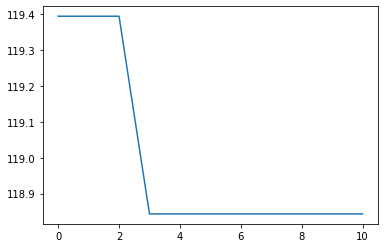

In [11]:
dct_to_df['best_penalty'].plot()

In [12]:
dct_to_df

,avg_distance,penalties,best_penalty,3
0,176.952608,119.394940,119.394940,NaN
1,177.134841,119.612463,119.394940,5.0
2,176.779039,118.843326,119.394940,5.0
3,176.777939,118.843896,118.843326,4.0
4,176.946730,119.393255,118.843326,1.0
5,176.992985,119.477707,118.843326,2.0
6,176.999651,119.432454,118.843326,5.0
7,176.952412,119.395131,118.843326,1.0
8,176.973513,119.406404,118.843326,3.0
9,177.160523,119.677040,118.843326,3.0
